In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:


def get_local_alt(f):
    to_local = lambda f : f.replace('/eos/user/e/ekoenig/','/store/user/ekoenig/')
    alt_pattern = to_local(f)

    alt_glob = fc.fs.eos.glob(alt_pattern)
    if any(alt_glob):
        return alt_glob
    
    remote_glob = fc.fs.cernbox.glob(f)
    if any(remote_glob):
        alt_glob = [ to_local(f) for f in remote_glob ]
        remote_glob = [ fc.fs.cernbox.fullpath(f) for f in remote_glob ]
        fc.fs.eos.batch_copy_to(remote_glob, alt_glob)

    alt_glob = fc.fs.eos.glob(alt_pattern)
    return alt_glob

In [3]:
def n_loose_btag(t):
    nL = t.ak4_h1b1_btag_L + t.ak4_h1b2_btag_L + t.ak4_h2b1_btag_L + t.ak4_h2b2_btag_L
    return ak.values_astype(nL, np.int32)
def n_medium_btag(t):
    nM = t.ak4_h1b1_btag_M + t.ak4_h1b2_btag_M + t.ak4_h2b1_btag_M + t.ak4_h2b2_btag_M
    return ak.values_astype(nM, np.int32)

In [4]:

treekwargs = dict(
    use_gen=False,
    treename='Events',
    normalization=None,
)

pairing='btagfix/feynnet'


f_pattern = '/eos/user/e/ekoenig/Ntuples/NanoHH4b/trg/{pairing}_sig_2018_0L/mc/ggHH4b_tree.root'
f_sig = f_pattern.format(pairing=pairing)

signal = ObjIter([Tree( get_local_alt(f_sig), **treekwargs)])


f_pattern = '/eos/user/e/ekoenig/Ntuples/NanoHH4b/trg/{pairing}_2018_0L/mc/qcd-mg_tree.root'
f_qcd = f_pattern.format(pairing=pairing)

bkg = ObjIter([Tree( get_local_alt(f_qcd), **treekwargs), ])

# f_pattern = '/eos/user/e/ekoenig/Ntuples/NanoHH4b/trg/{pairing}_2018_0L/data/jetht_tree.root'
# f_data = f_pattern.format(pairing='btagfix/feynnet')

# data = ObjIter([Tree( get_local_alt(f_data), **dict(treekwargs, normalization=None, color='black'))])

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


In [5]:
(signal + bkg).apply(lambda t : t.extend(scale = t.genWeight * t.xsecWeight / 1000))

[None, None]

In [6]:
tree = signal[0].subset(nentries=1000, randomize=False)

In [8]:
feynnet = '/eos/uscms/store/user/ekoenig/lightning/models/feynnet_lightning/nanoHH4b/training-25Sep2023/sixjet/lightning_logs/version_11194230'
load_feynnet = fourb.nanohh4b.f_evaluate_feynnet(feynnet)
import multiprocess as mp
load_feynnet(tree)
# (signal + bkg).apply(load_feynnet, report=True)

ValueError: in ListArray64 attempting to get 5, index out of range

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.2/src/cpu-kernels/awkward_ListArray_getitem_jagged_apply.cpp#L43)

100%|██████████| 1/1 [00:06<00:00,  6.57s/it]


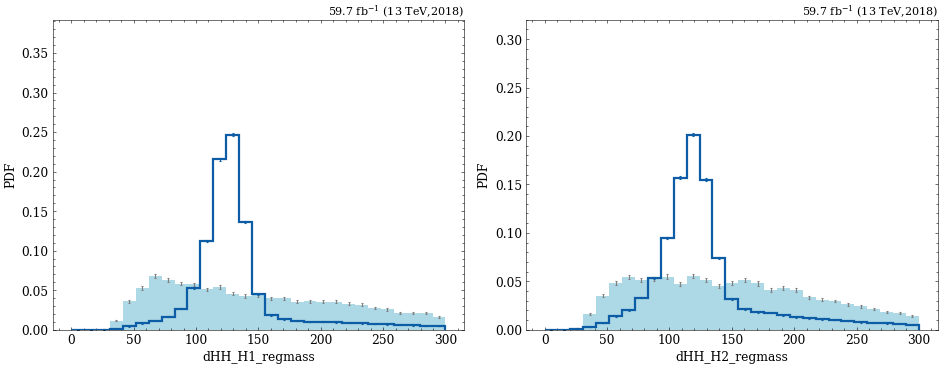

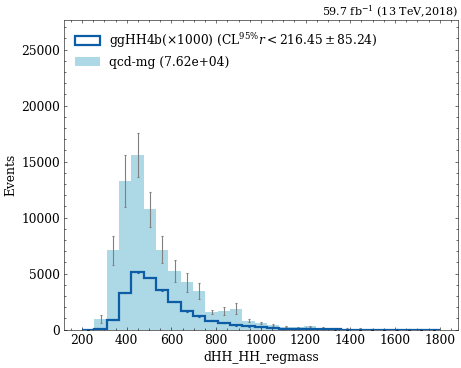

In [6]:
study.quick(
    signal+bkg,
    varlist=['dHH_H1_regmass','dHH_H2_regmass'],
    binlist=[(0,300,30)]*2, efficiency=True,
)

study.quick(
    signal + bkg,
    masks=lambda t : np.sqrt( (t.dHH_H1_regmass - 125)**2 + (t.dHH_H2_regmass - 120)**2 ) < 25,
    plot_scale=[1000],
    varlist=['dHH_HH_regmass'],
    binlist=[(200,1800,30)],
    legend=True, limits=True,
)

In [7]:
signal.apply(fourb.nanohh4b.match_ak4_gen)

[None]

100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


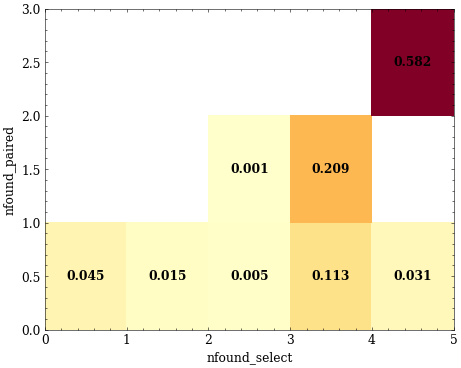

In [8]:
study.quick2d(
    signal,
    varlist=['nfound_select','nfound_paired'],
    efficiency=True,
    show_counts=lambda v : f'{v:0.3f}',
    # legend=True,
    # h_label_stat=lambda h : f'{h.histo[-1]:0.2%}'
)

In [16]:
0.582 / (0.582 + 0.031)

0.9494290375203914

In [9]:
spanet = '/eos/uscms/store/user/ekoenig/lightning/models/spanet/training-25Sep2023/v2'
load_spanet = fourb.nanohh4b.f_evaluate_spanet(spanet)
import multiprocess as mp

with mp.Pool(2) as pool:
    (signal + bkg).parallel_apply(load_spanet, pool=pool, report=True)

100%|██████████| 1/1 [00:05<00:00,  5.04s/it]


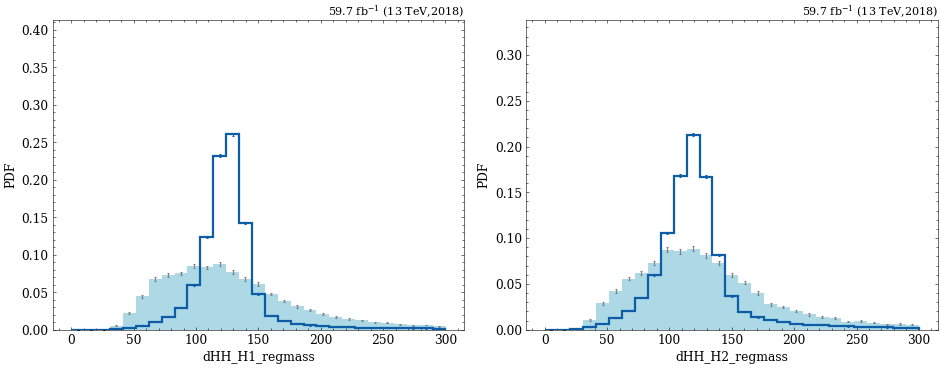

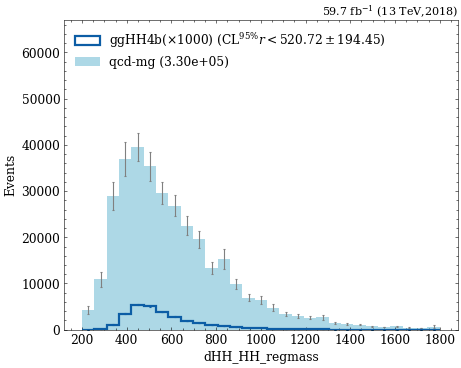

In [11]:
study.quick(
    signal+bkg,
    varlist=['dHH_H1_regmass','dHH_H2_regmass'],
    binlist=[(0,300,30)]*2, efficiency=True,
)

study.quick(
    signal + bkg,
    masks=lambda t : np.sqrt( (t.dHH_H1_regmass - 125)**2 + (t.dHH_H2_regmass - 120)**2 ) < 25,
    plot_scale=[1000],
    varlist=['dHH_HH_regmass'],
    binlist=[(200,1800,30)],
    legend=True, limits=True,
)

In [12]:
signal.apply(fourb.nanohh4b.match_ak4_gen)

[None]

100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


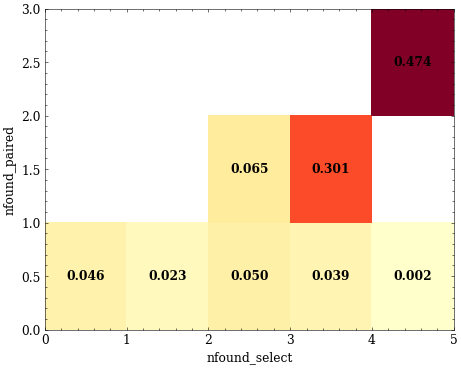

In [13]:
study.quick2d(
    signal,
    varlist=['nfound_select','nfound_paired'],
    efficiency=True,
    show_counts=lambda v : f'{v:0.3f}',
    # legend=True,
    # h_label_stat=lambda h : f'{h.histo[-1]:0.2%}'
)

In [17]:
0.474 / (0.474 + 0.002)

0.9957983193277311

100%|██████████| 2/2 [00:00<00:00,  4.82it/s]


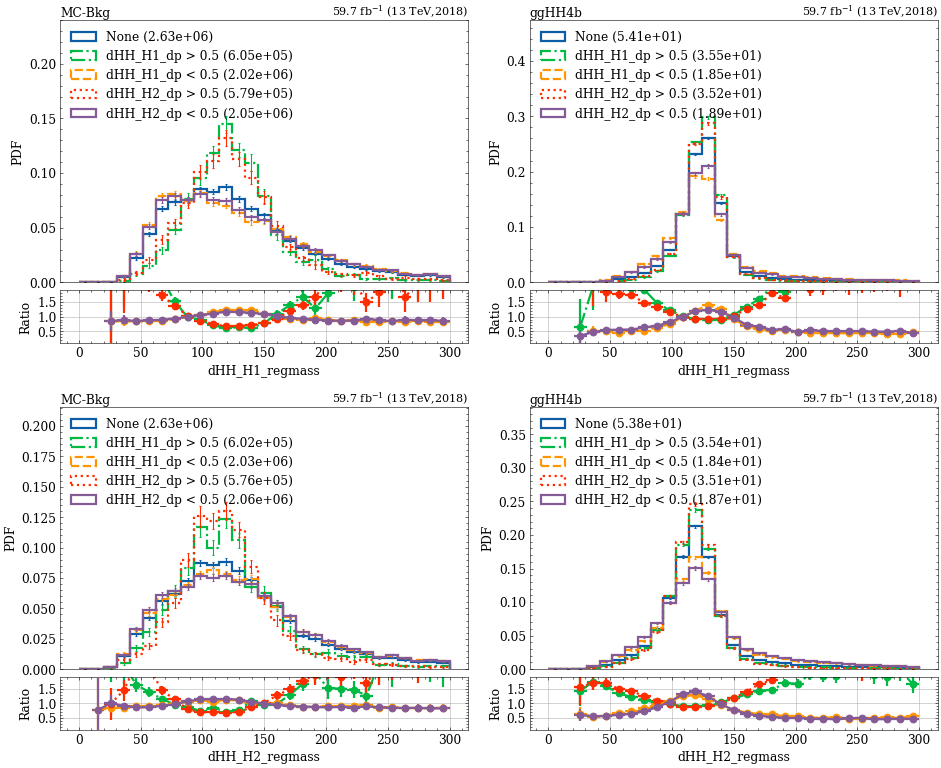

In [65]:
study.compare_masks(
    signal, bkg,
    legend=True,
    h_color=None,
    masks=[None, 'dHH_H1_dp > 0.5', 'dHH_H1_dp < 0.5','dHH_H2_dp > 0.5', 'dHH_H2_dp < 0.5'],
    varlist=['dHH_H1_regmass','dHH_H2_regmass'],
    binlist=[(0,300,30)]*2,
    efficiency=True,
    ratio=True,
)

100%|██████████| 1/1 [00:00<00:00,  6.23it/s]


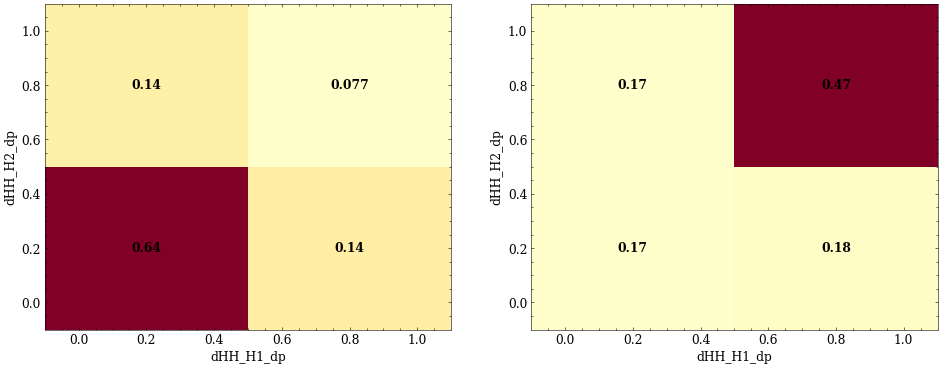

In [24]:
study.quick2d(
    signal + bkg,
    varlist=['dHH_H1_dp','dHH_H2_dp'],
    binlist=[np.array([-0.1,0.5,1.1])]*2,
    efficiency=True, show_counts=True
)

100%|██████████| 2/2 [00:00<00:00,  6.13it/s]


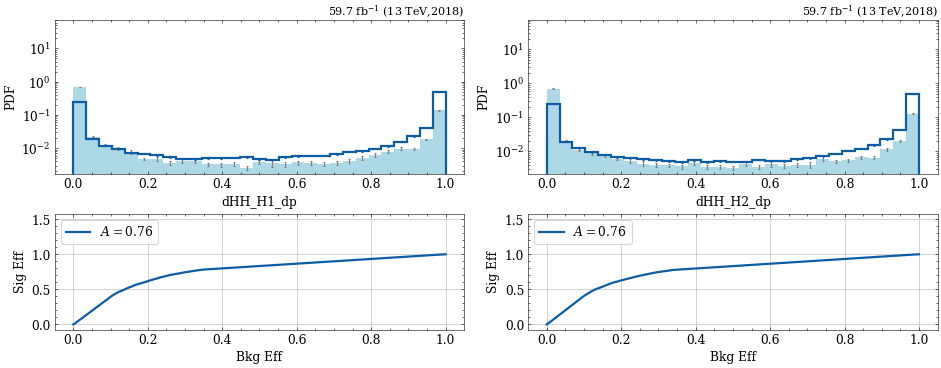

In [38]:
study.quick(
    signal + bkg,
    varlist=['dHH_H1_dp', 'dHH_H2_dp'],
    efficiency=True, log=True,
    **study.auroc
)